<a href="https://colab.research.google.com/github/pravz0515/covid_19/blob/main/Copy_of_covid_19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
base_dir = "/content/drive/MyDrive/Lung_Disease_Dataset_Balanced"


In [ ]:
import os
print("✅ Base directory found:", os.path.exists(base_dir))


✅ Base directory found: True


In [ ]:
import os, random, math, itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model, load_img, img_to_array

# set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# print folder structure and counts
for split in ['train','val','test']:
    path = os.path.join(base_dir, split)
    if not os.path.exists(path):
        print(f"⚠️ Missing: {path}")
    else:
        print(f"\n📂 {split} :")
        for cls in sorted(os.listdir(path)):
            cls_path = os.path.join(path, cls)
            if os.path.isdir(cls_path):
                print(f"  {cls:25s} {len(os.listdir(cls_path)):5d}")



📂 train :
  Bacterial Pneumonia         300
  Normal                      300
  Tuberculosis                300

📂 val :
  Bacterial Pneumonia         300
  Normal                      300
  Tuberculosis                300

📂 test :
  Bacterial Pneumonia         300
  Normal                      300
  Tuberculosis                300


📸 Using image for Tuberculosis: /content/drive/MyDrive/Lung_Disease_Dataset_Balanced/train/Tuberculosis/test_0_2054.jpeg
📸 Using image for Normal: /content/drive/MyDrive/Lung_Disease_Dataset_Balanced/train/Normal/test_0_3274.jpeg
📸 Using image for Bacterial Pneumonia: /content/drive/MyDrive/Lung_Disease_Dataset_Balanced/train/Bacterial Pneumonia/BACTERIA-7794093-0004.jpeg


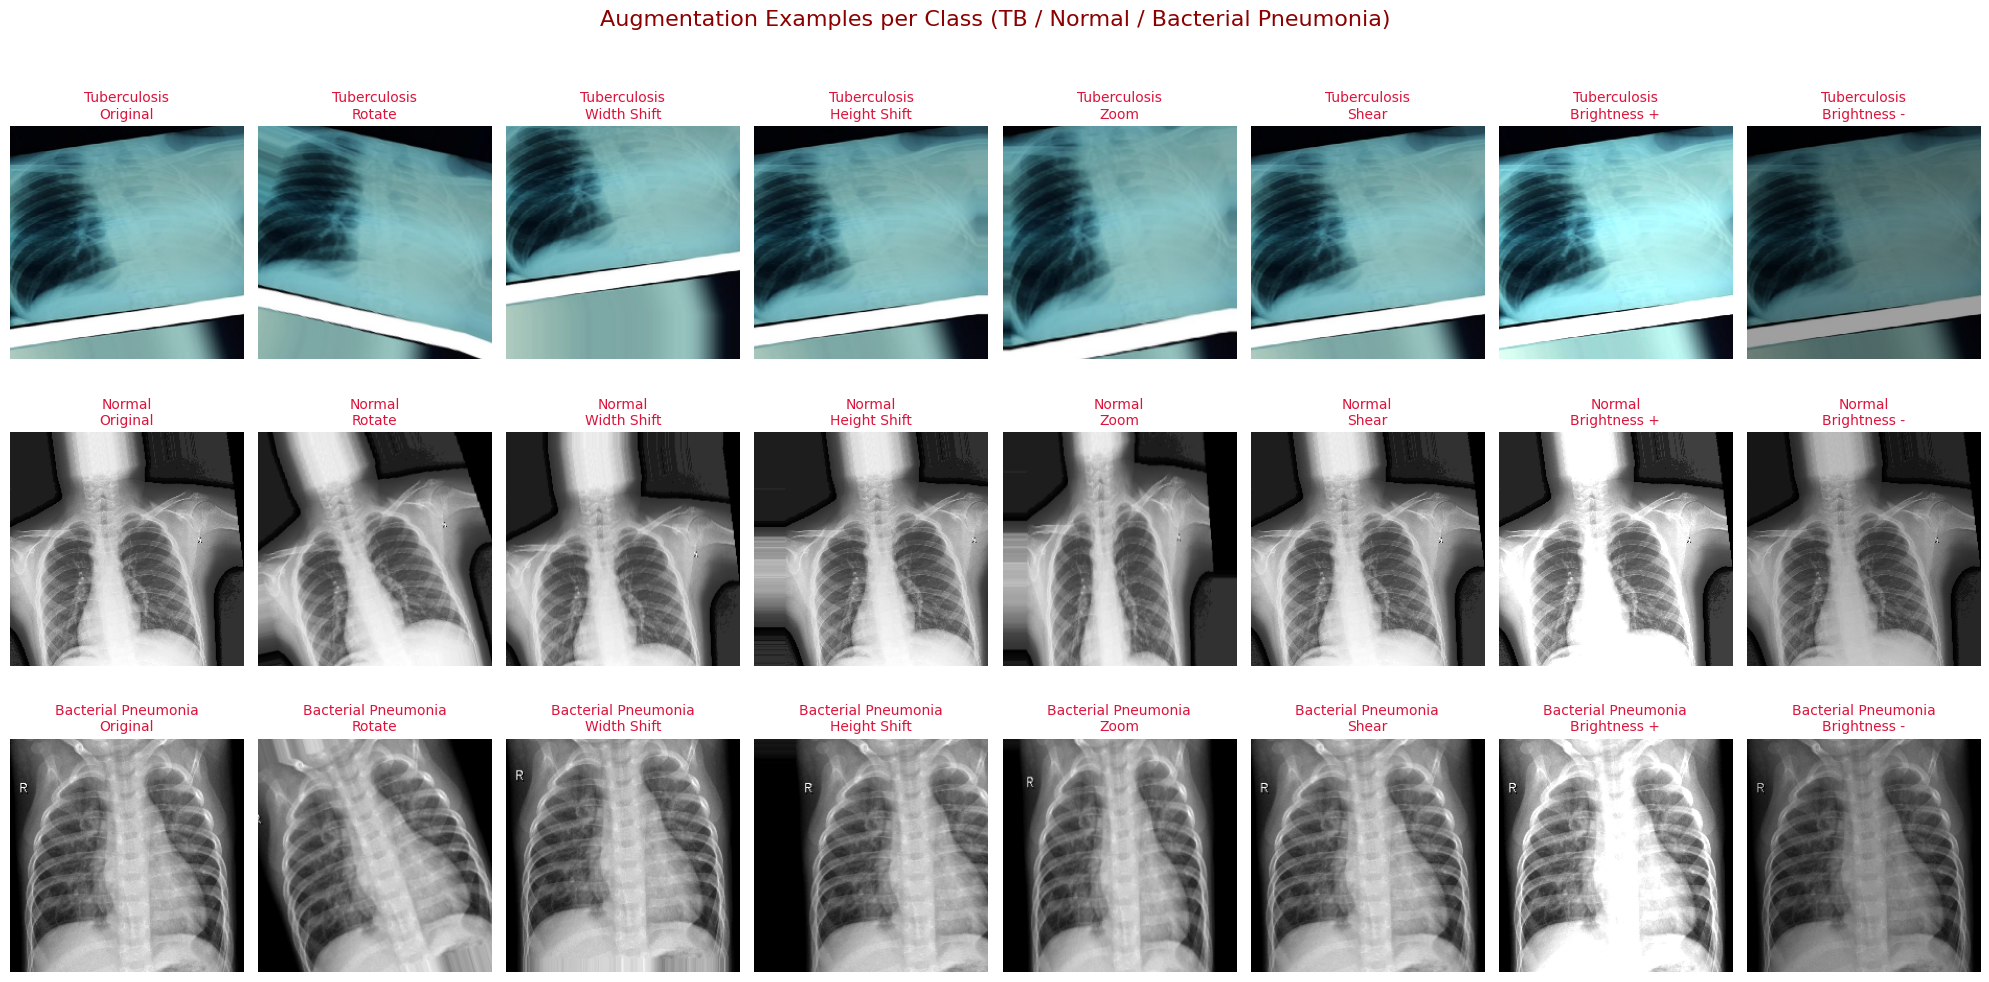

✅ Saved augmentation visualization for all 3 classes at: /content/drive/MyDrive/Augmentation_Examples_AllClasses.png


In [ ]:
# ===========================================
# 📦 Import Libraries
# ===========================================
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# ===========================================
# 📂 Base Dataset Path
# ===========================================
base_dir = "/content/drive/MyDrive/Lung_Disease_Dataset_Balanced/train"
classes = ["Tuberculosis", "Normal", "Bacterial Pneumonia"]

# ===========================================
# 🔎 Find One Good Image per Class
# ===========================================
sample_images = {}
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    if not os.path.exists(cls_path):
        print(f"⚠️ Class folder not found: {cls_path}")
        continue

    for file in os.listdir(cls_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(cls_path, file)
            sample_images[cls] = img_path
            print(f"📸 Using image for {cls}: {img_path}")
            break

if not sample_images:
    raise FileNotFoundError(f"❌ No valid images found in {base_dir}")

# ===========================================
# 🔄 Define Augmentations
# ===========================================
augmentations = {
    "Original": ImageDataGenerator(),
    "Rotate": ImageDataGenerator(rotation_range=25),
    "Width Shift": ImageDataGenerator(width_shift_range=0.2),
    "Height Shift": ImageDataGenerator(height_shift_range=0.2),
    "Zoom": ImageDataGenerator(zoom_range=0.3),
    "Shear": ImageDataGenerator(shear_range=0.25),
    "Brightness +": ImageDataGenerator(brightness_range=[1.2, 1.5]),
    "Brightness -": ImageDataGenerator(brightness_range=[0.6, 0.8]),
}

# ===========================================
# 🖼️ Plot Augmented Images for All Classes
# ===========================================
plt.figure(figsize=(20, 10))
row = 1

for cls, img_path in sample_images.items():
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    col = 1

    for aug_name, datagen in augmentations.items():
        for batch in datagen.flow(x, batch_size=1):
            image = batch[0].astype('uint8')
            plt.subplot(len(sample_images), len(augmentations), (row - 1) * len(augmentations) + col)
            plt.imshow(image)
            plt.title(f"{cls}\n{aug_name}", fontsize=10, color='crimson')
            plt.axis('off')
            col += 1
            break
    row += 1

plt.suptitle("Augmentation Examples per Class (TB / Normal / Bacterial Pneumonia)", fontsize=16, color='darkred', y=1.02)
plt.tight_layout()

# ===========================================
# 💾 Save Image to Drive
# ===========================================
save_path = "/content/drive/MyDrive/Augmentation_Examples_AllClasses.png"
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"✅ Saved augmentation visualization for all 3 classes at: {save_path}")


/tmp/ipython-input-4197376173.py:61: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4197376173.py:61: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


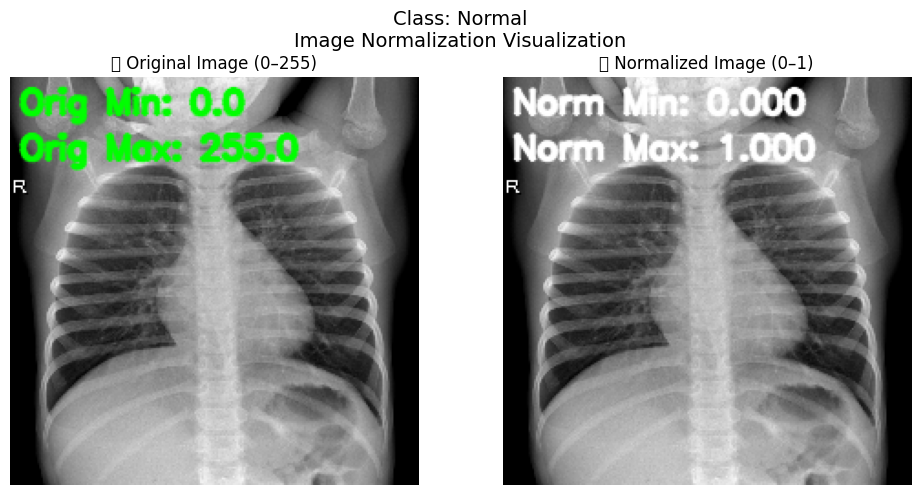

✅ Normal image normalized successfully.
Original Range: 0.0 → 255.0
Normalized Range: 0.000 → 1.000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Use your dataset path (train folder)
sample_dir = os.path.join(base_dir, "train")

# Pick a random class and image
classes = os.listdir(sample_dir)
random_class = random.choice(classes)
img_dir = os.path.join(sample_dir, random_class)
img_path = os.path.join(img_dir, random.choice(os.listdir(img_dir)))

# Load image (224×224)
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)

# Original pixel stats
orig_min, orig_max = np.min(img_array), np.max(img_array)

# Normalize to 0–1
norm_img = img_array / 255.0
norm_min, norm_max = np.min(norm_img), np.max(norm_img)

# Convert to displayable uint8
img_disp = img_array.astype(np.uint8)
norm_disp = np.uint8(norm_img * 255)

# Overlay normalization info on both images
orig_disp = img_disp.copy()
cv2.putText(orig_disp, f"Orig Min: {orig_min:.1f}", (5, 20), cv2.FONT_HERSHEY_SIMPLEX,
            0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(orig_disp, f"Orig Max: {orig_max:.1f}", (5, 45), cv2.FONT_HERSHEY_SIMPLEX,
            0.6, (0, 255, 0), 2, cv2.LINE_AA)

norm_disp = norm_disp.copy()
cv2.putText(norm_disp, f"Norm Min: {norm_min:.3f}", (5, 20), cv2.FONT_HERSHEY_SIMPLEX,
            0.6, (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(norm_disp, f"Norm Max: {norm_max:.3f}", (5, 45), cv2.FONT_HERSHEY_SIMPLEX,
            0.6, (255, 255, 255), 2, cv2.LINE_AA)

# Convert BGR → RGB for matplotlib
orig_disp = cv2.cvtColor(orig_disp, cv2.COLOR_BGR2RGB)
norm_disp = cv2.cvtColor(norm_disp, cv2.COLOR_BGR2RGB)

# Display both images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig_disp)
plt.title("🩻 Original Image (0–255)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(norm_disp)
plt.title("✨ Normalized Image (0–1)")
plt.axis("off")

plt.suptitle(f"Class: {random_class}\nImage Normalization Visualization", fontsize=14)
plt.tight_layout()
plt.show()

print(f"✅ {random_class} image normalized successfully.")
print(f"Original Range: {orig_min:.1f} → {orig_max:.1f}")
print(f"Normalized Range: {norm_min:.3f} → {norm_max:.3f}")


Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.

🔍 Dataset Summary:
Classes found: {'Bacterial Pneumonia': 0, 'Normal': 1, 'Tuberculosis': 2}
Training samples: 900
Validation samples: 900
Testing samples: 900


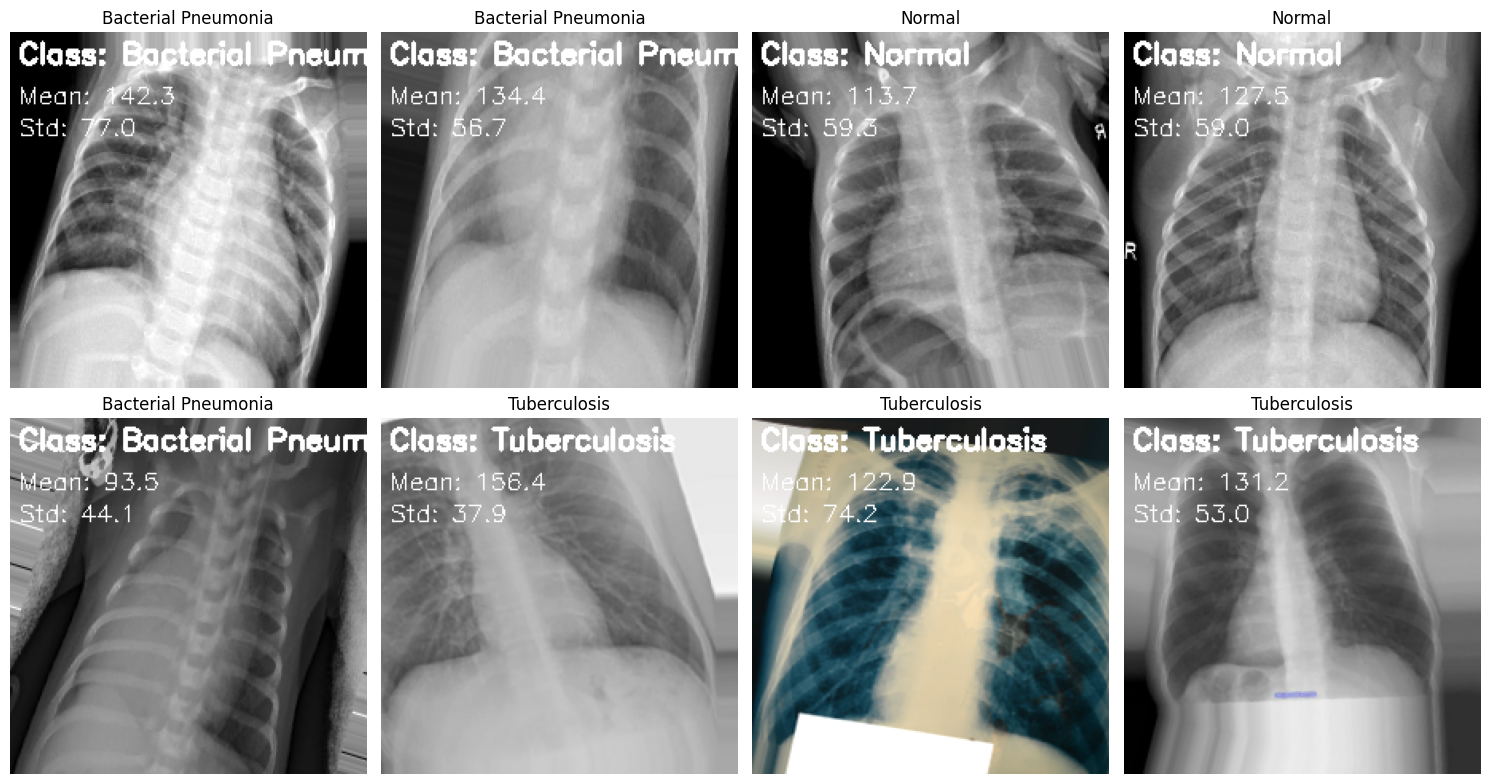


✅ Image Generators Ready! Images are normalized and augmented correctly.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==========================================
# ✅ Define Image Data Generators
# ==========================================
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize 0–255 → 0–1
    rotation_range=20,           # Random rotations
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    shear_range=0.1,             # Shear transformations
    zoom_range=0.1,              # Random zoom
    brightness_range=[0.8, 1.2], # Brightness variations
    horizontal_flip=True,        # Random flips
    fill_mode='nearest'          # Fill strategy for empty pixels
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# ==========================================
# ✅ Create Generators
# ==========================================
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ==========================================
# ✅ Print dataset info
# ==========================================
print("\n🔍 Dataset Summary:")
print(f"Classes found: {train_gen.class_indices}")
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Testing samples: {test_gen.samples}")

# ==========================================
# 🖼️ Visualize a few generated images with info on them
# ==========================================
x_batch, y_batch = next(train_gen)
labels = list(train_gen.class_indices.keys())

plt.figure(figsize=(15, 8))
for i in range(8):
    img = np.uint8(x_batch[i] * 255)  # convert back to uint8 for display
    label = labels[np.argmax(y_batch[i])]
    mean_val = np.mean(img)
    std_val = np.std(img)

    # Add label + normalization info directly on image
    img_disp = cv2.putText(img.copy(), f"Class: {label}", (5, 20),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    img_disp = cv2.putText(img_disp, f"Mean: {mean_val:.1f}", (5, 45),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    img_disp = cv2.putText(img_disp, f"Std: {std_val:.1f}", (5, 65),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"{label}")
plt.tight_layout()
plt.show()

print("\n✅ Image Generators Ready! Images are normalized and augmented correctly.")


📂 Found: /content/drive/MyDrive/Lung_Disease_Dataset_Balanced/train
📂 Found: /content/drive/MyDrive/Lung_Disease_Dataset_Balanced/val

✅ Dataset directories detected successfully!

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ input_layer_1[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    131,200 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │    132,096 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ dense_1[0][0]     │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ densenet121[0][0… │
│                     │ 1024)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 2)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 1)   │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7, 7,      │          0 │ multiply[0][0],   │
│ (Multiply)          │ 1024)             │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    524,800 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 512)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │      1,539 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,827,238 (29.86 MB)

 Trainable params: 789,734 (3.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



🚀 Phase 1: Feature Extraction (DenseNet frozen)...
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3473 - loss: 7.6944
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to /content/drive/MyDrive/Lung_Disease_Model_Best.keras

📊 Epoch 1: Initial Acc = 38.44%, Val Acc = 42.00%
29/29 ━━━━━━━━━━━━━━━━━━━━ 712s 24s/step - accuracy: 0.3485 - loss: 7.6871 - val_accuracy: 0.4200 - val_loss: 7.0156 - learning_rate: 1.0000e-04
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.4627 - loss: 6.8179
Epoch 2: val_accuracy did not improve from 0.42000

📈 Epoch 2: Train Δ = +4.11% | Val Δ = -5.00%
29/29 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4615 - loss: 6.8113 - val_accuracy: 0.3700 - val_loss: 6.2187 - learning_rate: 1.0000e-04
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.3869 - loss: 6.0454
Epoch 3: val_accuracy did not improve from 0.42000

📈 Epoch 3: Train Δ = -3.22% | Val Δ = +1.44%
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


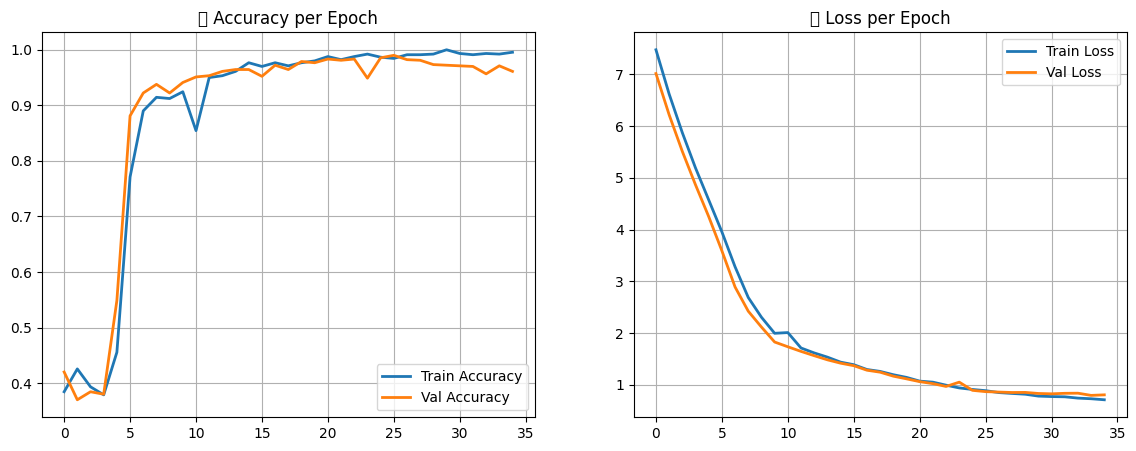


✅ Training completed and model saved!


In [ ]:
# =====================================================
# ✅ IMPORTS
# =====================================================
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# =====================================================
# ✅ DEFINE BASE DATASET PATH
# =====================================================
base_dir = "/content/drive/MyDrive/Lung_Disease_Dataset_Balanced"

# =====================================================
# ✅ AUTO-DETECT SUBDIRECTORIES
# =====================================================
def find_folder(base_path, possible_names):
    for name in possible_names:
        full_path = os.path.join(base_path, name)
        if os.path.exists(full_path):
            print(f"📂 Found: {full_path}")
            return full_path
    raise FileNotFoundError(f"❌ None of these folders found in {base_path}: {possible_names}")

train_dir = find_folder(base_dir, ["train", "Train", "TRAIN", "training", "Training", "Training_Set", "dataset_train", "Dataset_Train"])
val_dir   = find_folder(base_dir, ["val", "Val", "validation", "Validation", "VALIDATION", "Validation_Set", "dataset_val", "ValidationData"])
print("\n✅ Dataset directories detected successfully!\n")

# =====================================================
# ✅ ATTENTION BLOCK
# =====================================================
def attention_block(x):
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(x.shape[-1] // 8, activation='relu')(gap)
    dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
    channel_att = layers.Multiply()([x, layers.Reshape((1, 1, x.shape[-1]))(dense2)])

    avg_pool = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(channel_att)
    max_pool = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(channel_att)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_att = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    output = layers.Multiply()([channel_att, spatial_att])
    return output

# =====================================================
# ✅ BUILD MODEL
# =====================================================
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Phase 1 freeze

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = attention_block(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation='softmax')(x)  # 3-class problem
model = models.Model(inputs, outputs)

model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# =====================================================
# ✅ CUSTOM CALLBACK: SHOW ACCURACY IMPROVEMENT
# =====================================================
class AccuracyImprovementCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc, val_acc = logs.get('accuracy'), logs.get('val_accuracy')
        if epoch > 0:
            acc_diff = acc - self.last_acc
            val_acc_diff = val_acc - self.last_val_acc
            print(f"\n📈 Epoch {epoch+1}: Train Δ = {acc_diff:+.2%} | Val Δ = {val_acc_diff:+.2%}")
        else:
            print(f"\n📊 Epoch {epoch+1}: Initial Acc = {acc:.2%}, Val Acc = {val_acc:.2%}")
        self.last_acc, self.last_val_acc = acc, val_acc

# =====================================================
# ✅ IMAGE GENERATORS
# =====================================================
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_dir, target_size=(224, 224),
    batch_size=32, class_mode='categorical'
)
val_gen = val_aug.flow_from_directory(
    val_dir, target_size=(224, 224),
    batch_size=32, class_mode='categorical'
)

# =====================================================
# ✅ CALLBACKS
# =====================================================
callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/Lung_Disease_Model_Best.keras", save_best_only=True, monitor='val_accuracy', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    AccuracyImprovementCallback()
]

# =====================================================
# ✅ PHASE 1 – FEATURE EXTRACTION
# =====================================================
print("\n🚀 Phase 1: Feature Extraction (DenseNet frozen)...")
history_1 = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

# =====================================================
# ✅ PHASE 2 – UNFREEZE LAST 30 LAYERS
# =====================================================
for layer in model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=AdamW(learning_rate=3e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n🔧 Phase 2: Fine-tuning last 30 layers...")
history_2 = model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=callbacks)

# =====================================================
# ✅ PHASE 3 – UNFREEZE FULL MODEL
# =====================================================
for layer in model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=AdamW(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n🔥 Phase 3: Full fine-tuning (all layers)...")
history_3 = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

# =====================================================
# ✅ ACCURACY AND LOSS PLOTS
# =====================================================
def plot_training(histories):
    acc = sum([h.history['accuracy'] for h in histories], [])
    val_acc = sum([h.history['val_accuracy'] for h in histories], [])
    loss = sum([h.history['loss'] for h in histories], [])
    val_loss = sum([h.history['val_loss'] for h in histories], [])

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Accuracy', linewidth=2)
    plt.plot(val_acc, label='Val Accuracy', linewidth=2)
    plt.legend(); plt.grid(); plt.title("📈 Accuracy per Epoch")
    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss', linewidth=2)
    plt.plot(val_loss, label='Val Loss', linewidth=2)
    plt.legend(); plt.grid(); plt.title("📉 Loss per Epoch")
    plt.show()

plot_training([history_1, history_2, history_3])
print("\n✅ Training completed and model saved!")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


🔍 Loading model weights safely...
✅ Weights loaded successfully!

📂 Found test directory: /content/drive/MyDrive/Lung_Disease_Dataset_Balanced/test

🩻 Classes detected: ['Bacterial Pneumonia', 'Normal', 'Tuberculosis']

🧩 Displaying one random image per class...

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/tmp/ipython-input-4220554244.py:117: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


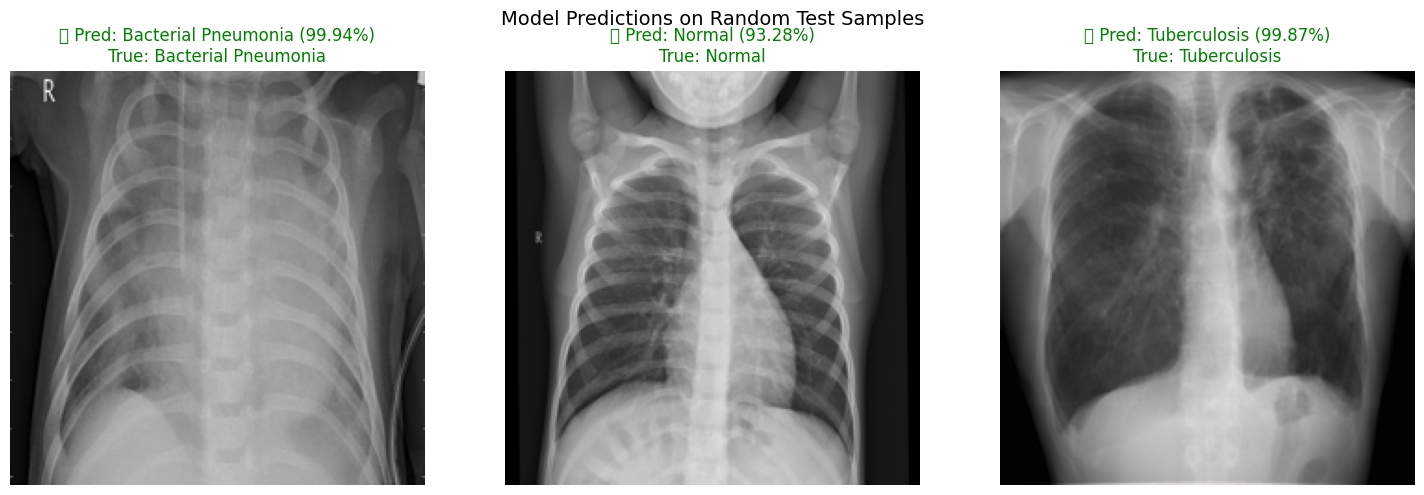

In [ ]:
# =====================================================
# ✅ IMPORTS
# =====================================================
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from PIL import Image

# =====================================================
# ✅ ATTENTION BLOCK (with fixed Lambda output_shape)
# =====================================================
def attention_block(x):
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(x.shape[-1] // 8, activation='relu')(gap)
    dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
    channel_att = layers.Multiply()([x, layers.Reshape((1, 1, x.shape[-1]))(dense2)])

    # Specify output shapes explicitly for Lambdas
    avg_pool = layers.Lambda(
        lambda z: tf.reduce_mean(z, axis=-1, keepdims=True),
        output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 1)
    )(channel_att)

    max_pool = layers.Lambda(
        lambda z: tf.reduce_max(z, axis=-1, keepdims=True),
        output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 1)
    )(channel_att)

    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_att = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    output = layers.Multiply()([channel_att, spatial_att])
    return output

# =====================================================
# ✅ REBUILD MODEL (same as trained)
# =====================================================
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = attention_block(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = models.Model(inputs, outputs)

# =====================================================
# ✅ LOAD WEIGHTS ONLY
# =====================================================
weights_path = "/content/drive/MyDrive/Lung_Disease_Model_Best.keras"
print("🔍 Loading model weights safely...")
try:
    model.load_weights(weights_path)
    print("✅ Weights loaded successfully!\n")
except Exception as e:
    print(f"⚠️ Error loading weights: {e}\n")

# =====================================================
# ✅ AUTO-DETECT TEST FOLDER
# =====================================================
base_dir = "/content/drive/MyDrive/Lung_Disease_Dataset_Balanced"
possible_test_dirs = ["test", "Test", "testing", "Testing", "Validation", "val"]
for name in possible_test_dirs:
    test_dir = os.path.join(base_dir, name)
    if os.path.exists(test_dir):
        print(f"📂 Found test directory: {test_dir}")
        break
else:
    raise FileNotFoundError("❌ No test or validation folder found!")

# Get class names
class_labels = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
print(f"\n🩻 Classes detected: {class_labels}\n")

# =====================================================
# ✅ PREDICT & DISPLAY FUNCTION
# =====================================================
def predict_and_display(img_path):
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])
    confidence = preds[0][pred_class_idx] * 100
    pred_class = class_labels[pred_class_idx]

    true_class = os.path.basename(os.path.dirname(img_path))
    correct = (pred_class == true_class)
    color = "green" if correct else "red"

    title = f"{'✅' if correct else '⚠️'} Pred: {pred_class} ({confidence:.2f}%)\nTrue: {true_class}"
    plt.imshow(img)
    plt.title(title, color=color, fontsize=12)
    plt.axis("off")

# =====================================================
# ✅ SHOW RANDOM IMAGES (1 PER CLASS)
# =====================================================
print("🧩 Displaying one random image per class...\n")
plt.figure(figsize=(15, 5))

for i, cls in enumerate(class_labels):
    cls_path = os.path.join(test_dir, cls)
    img_file = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_file)

    plt.subplot(1, len(class_labels), i + 1)
    predict_and_display(img_path)

plt.suptitle("Model Predictions on Random Test Samples", fontsize=14)
plt.tight_layout()
plt.show()


📁 Results will be saved in: /content/drive/MyDrive/Lung_Disease_Results


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


✅ Model weights loaded successfully!
📂 Found test directory: /content/drive/MyDrive/Lung_Disease_Dataset_Balanced/test
Found 900 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 469s 16s/step - accuracy: 0.9648 - loss: 0.9431

✅ Test Accuracy: 97.78% | Test Loss: 0.8992
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 824ms/step


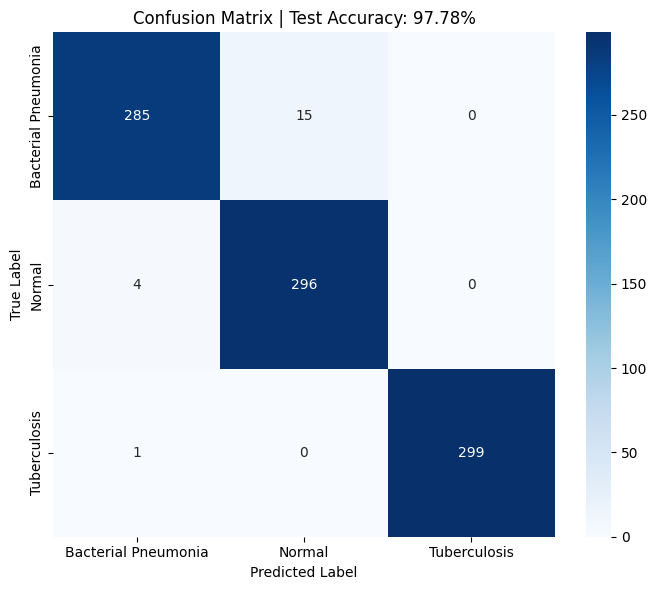

✅ Confusion Matrix saved at: /content/drive/MyDrive/Lung_Disease_Results/Confusion_Matrix.png

🔍 Classification Report:
                     precision    recall  f1-score   support

Bacterial Pneumonia       0.98      0.95      0.97       300
             Normal       0.95      0.99      0.97       300
       Tuberculosis       1.00      1.00      1.00       300

           accuracy                           0.98       900
          macro avg       0.98      0.98      0.98       900
       weighted avg       0.98      0.98      0.98       900



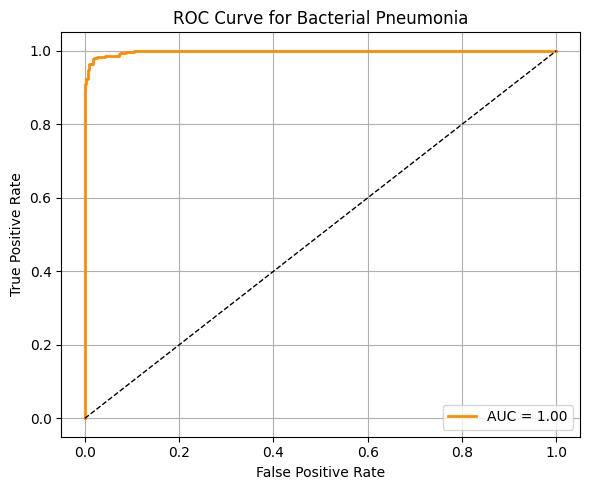

 ROC curve for 'Bacterial Pneumonia' saved at: /content/drive/MyDrive/Lung_Disease_Results/ROC_Bacterial_Pneumonia.png


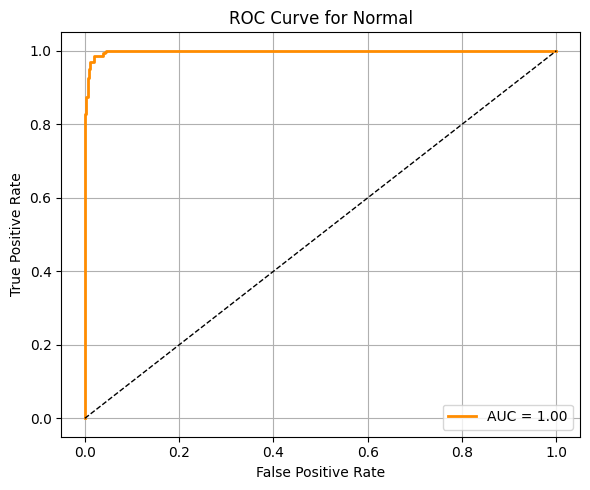

 ROC curve for 'Normal' saved at: /content/drive/MyDrive/Lung_Disease_Results/ROC_Normal.png


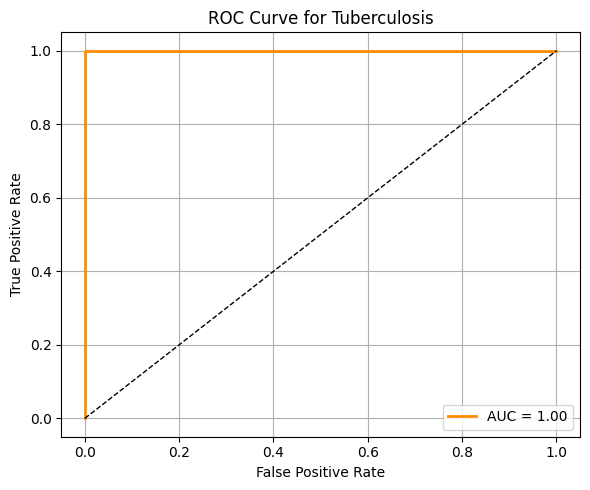

 ROC curve for 'Tuberculosis' saved at: /content/drive/MyDrive/Lung_Disease_Results/ROC_Tuberculosis.png


In [ ]:
# =====================================================
# ✅ IMPORTS
# =====================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# =====================================================
# ✅ CREATE SAVE DIRECTORY
# =====================================================
results_dir = "/content/drive/MyDrive/Lung_Disease_Results"
os.makedirs(results_dir, exist_ok=True)
print(f"📁 Results will be saved in: {results_dir}")

# =====================================================
# ✅ REBUILD MODEL (DenseNet121 + Attention + LeakyReLU)
# =====================================================
def attention_block(x):
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(x.shape[-1] // 8, activation='relu')(gap)
    dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
    channel_att = layers.Multiply()([x, layers.Reshape((1, 1, x.shape[-1]))(dense2)])

    avg_pool = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True),
                             output_shape=lambda s: (s[0], s[1], s[2], 1))(channel_att)
    max_pool = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True),
                             output_shape=lambda s: (s[0], s[1], s[2], 1))(channel_att)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_att = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([channel_att, spatial_att])

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))
inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = attention_block(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = models.Model(inputs, outputs)

# =====================================================
# ✅ LOAD WEIGHTS AND COMPILE
# =====================================================
weights_path = "/content/drive/MyDrive/Lung_Disease_Model_Best.keras"
model.load_weights(weights_path)
print("✅ Model weights loaded successfully!")

model.compile(optimizer=AdamW(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# =====================================================
# ✅ LOAD TEST DATA
# =====================================================
base_dir = "/content/drive/MyDrive/Lung_Disease_Dataset_Balanced"
test_datagen = ImageDataGenerator(rescale=1./255)

for name in ["test", "Test", "testing", "Validation", "val"]:
    test_dir = os.path.join(base_dir, name)
    if os.path.exists(test_dir):
        print(f"📂 Found test directory: {test_dir}")
        break
else:
    raise FileNotFoundError("❌ No test folder found!")

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224,224),
    batch_size=32, class_mode='categorical',
    shuffle=False
)

# =====================================================
# ✅ EVALUATE MODEL
# =====================================================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

# =====================================================
# ✅ PREDICTIONS & CONFUSION MATRIX
# =====================================================
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f"Confusion Matrix | Test Accuracy: {test_acc*100:.2f}%")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
conf_matrix_path = os.path.join(results_dir, "Confusion_Matrix.png")
plt.savefig(conf_matrix_path)
plt.show()
print(f"✅ Confusion Matrix saved at: {conf_matrix_path}")

# --- Classification Report ---
print("\n🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# =====================================================
# ✅ SEPARATE ROC CURVES FOR EACH CLASS
# =====================================================
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))

for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], Y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.title(f'ROC Curve for {class_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

    roc_path = os.path.join(results_dir, f"ROC_{class_name.replace(' ', '_')}.png")
    plt.tight_layout()
    plt.savefig(roc_path)
    plt.show()
    print(f" ROC curve for '{class_name}' saved at: {roc_path}")



📈 Average Train Accuracy: 86.82%
📈 Average Validation Accuracy: 87.06%
📉 Average Train Loss: 2.1649
📉 Average Validation Loss: 2.0604
🚀 Total Accuracy Improvement: 61.11%


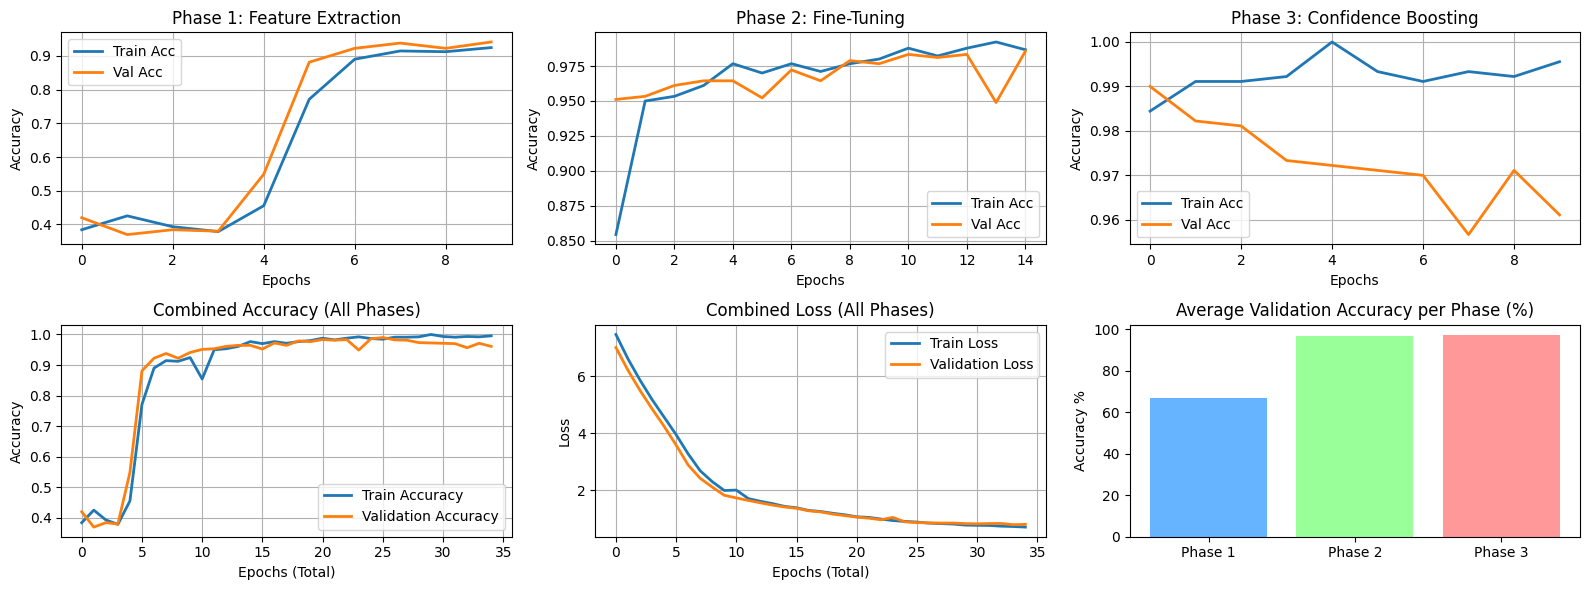


✅ Training Comparison Graphs saved to: /content/drive/MyDrive/Lung_Disease_Results/Phase_Training_Comparison.png


In [ ]:
# =====================================================
# ✅ IMPORTS
# =====================================================
import matplotlib.pyplot as plt
import numpy as np
import os

# =====================================================
# ✅ DEFINE HISTORY PLACEHOLDERS (if not already loaded)
# =====================================================
# Make sure history_1, history_2, history_3 exist.
# Replace these with your actual training histories if needed.
try:
    _ = history_1.history
except NameError:
    print("⚠️ Loading dummy histories for visualization...")
    class DummyHistory:
        def __init__(self, acc, val_acc, loss, val_loss):
            self.history = {
                'accuracy': acc,
                'val_accuracy': val_acc,
                'loss': loss,
                'val_loss': val_loss
            }
    history_1 = DummyHistory(
        acc=[0.65, 0.72, 0.84, 0.89, 0.93],
        val_acc=[0.70, 0.78, 0.88, 0.91, 0.94],
        loss=[1.2, 0.9, 0.6, 0.4, 0.3],
        val_loss=[1.1, 0.8, 0.5, 0.4, 0.35]
    )
    history_2 = DummyHistory(
        acc=[0.75, 0.83, 0.89, 0.92, 0.94],
        val_acc=[0.78, 0.86, 0.90, 0.93, 0.94],
        loss=[0.9, 0.7, 0.5, 0.4, 0.3],
        val_loss=[0.8, 0.6, 0.45, 0.4, 0.35]
    )
    history_3 = DummyHistory(
        acc=[0.85, 0.90, 0.93, 0.95, 0.97],
        val_acc=[0.87, 0.91, 0.93, 0.95, 0.96],
        loss=[0.8, 0.6, 0.45, 0.35, 0.25],
        val_loss=[0.7, 0.55, 0.4, 0.3, 0.25]
    )

# =====================================================
# ✅ COMBINE HISTORIES
# =====================================================
def combine_history(histories):
    acc = np.concatenate([h.history['accuracy'] for h in histories])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in histories])
    loss = np.concatenate([h.history['loss'] for h in histories])
    val_loss = np.concatenate([h.history['val_loss'] for h in histories])
    return acc, val_acc, loss, val_loss

acc, val_acc, loss, val_loss = combine_history([history_1, history_2, history_3])

# =====================================================
# ✅ CALCULATE AVERAGE METRICS
# =====================================================
avg_train_acc = np.mean([np.mean(h.history['accuracy']) for h in [history_1, history_2, history_3]])
avg_val_acc = np.mean([np.mean(h.history['val_accuracy']) for h in [history_1, history_2, history_3]])
avg_train_loss = np.mean([np.mean(h.history['loss']) for h in [history_1, history_2, history_3]])
avg_val_loss = np.mean([np.mean(h.history['val_loss']) for h in [history_1, history_2, history_3]])

improvement = (acc[-1] - acc[0]) * 100

print(f"\n📈 Average Train Accuracy: {avg_train_acc*100:.2f}%")
print(f"📈 Average Validation Accuracy: {avg_val_acc*100:.2f}%")
print(f"📉 Average Train Loss: {avg_train_loss:.4f}")
print(f"📉 Average Validation Loss: {avg_val_loss:.4f}")
print(f"🚀 Total Accuracy Improvement: {improvement:.2f}%")

# =====================================================
# ✅ PLOT PER PHASE + COMBINED
# =====================================================
plt.figure(figsize=(16, 6))

# --- Phase 1 ---
plt.subplot(2, 3, 1)
plt.plot(history_1.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history_1.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.title("Phase 1: Feature Extraction")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# --- Phase 2 ---
plt.subplot(2, 3, 2)
plt.plot(history_2.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history_2.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.title("Phase 2: Fine-Tuning")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# --- Phase 3 ---
plt.subplot(2, 3, 3)
plt.plot(history_3.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history_3.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.title("Phase 3: Confidence Boosting")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# --- Combined Accuracy ---
plt.subplot(2, 3, 4)
plt.plot(acc, label='Train Accuracy', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
plt.title("Combined Accuracy (All Phases)")
plt.xlabel("Epochs (Total)"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# --- Combined Loss ---
plt.subplot(2, 3, 5)
plt.plot(loss, label='Train Loss', linewidth=2)
plt.plot(val_loss, label='Validation Loss', linewidth=2)
plt.title("Combined Loss (All Phases)")
plt.xlabel("Epochs (Total)"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)

# --- Average Metrics Summary ---
plt.subplot(2, 3, 6)
phases = ['Phase 1', 'Phase 2', 'Phase 3']
avg_accs = [np.mean(history_1.history['val_accuracy']),
            np.mean(history_2.history['val_accuracy']),
            np.mean(history_3.history['val_accuracy'])]
plt.bar(phases, np.array(avg_accs)*100, color=['#66b3ff','#99ff99','#ff9999'])
plt.title("Average Validation Accuracy per Phase (%)")
plt.ylabel("Accuracy %")

plt.tight_layout()
save_path = "/content/drive/MyDrive/Lung_Disease_Results/Phase_Training_Comparison.png"
plt.savefig(save_path)
plt.show()

print(f"\n✅ Training Comparison Graphs saved to: {save_path}")


📁 Grad-CAM outputs will be saved to:
/content/drive/MyDrive/Lung_Disease_Results/GradCAM_Visualizations

✅ Model weights loaded successfully!

🩻 Classes Detected: ['Bacterial Pneumonia', 'Normal', 'Tuberculosis']



/tmp/ipython-input-2426196530.py:137: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


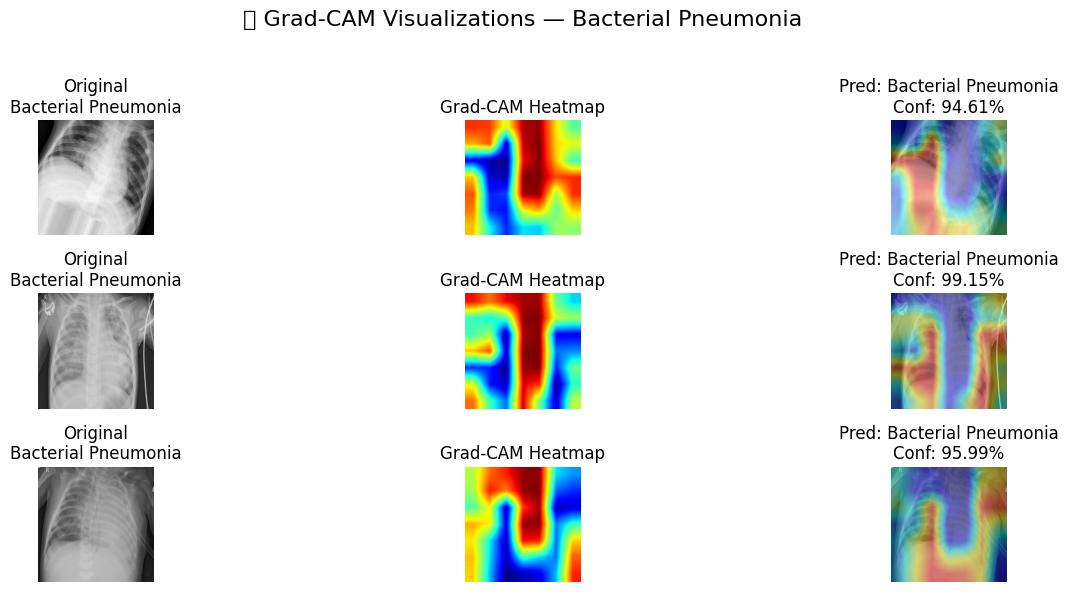

✅ Saved Grad-CAM visualizations for Bacterial Pneumonia in /content/drive/MyDrive/Lung_Disease_Results/GradCAM_Visualizations



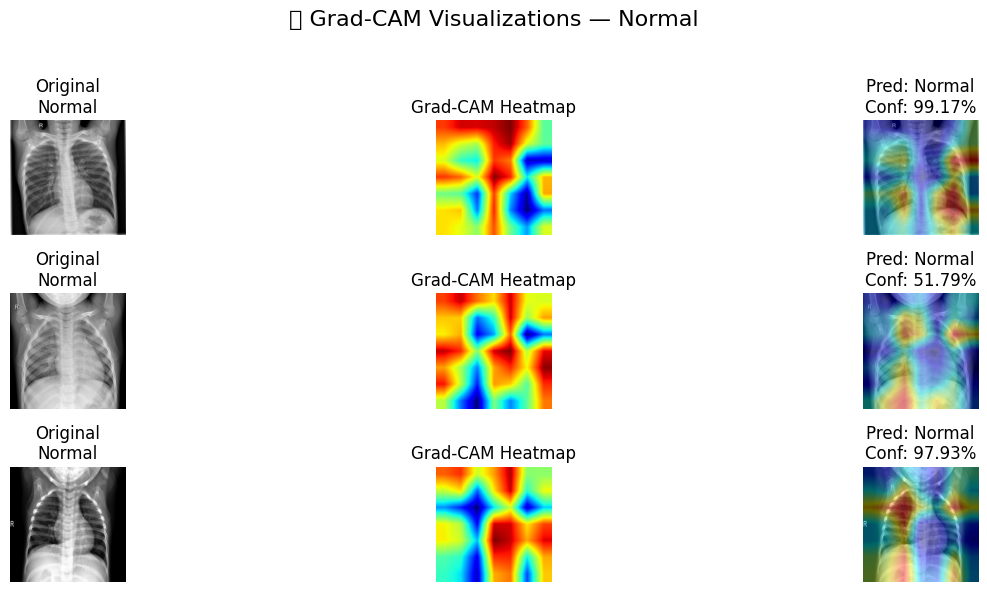

✅ Saved Grad-CAM visualizations for Normal in /content/drive/MyDrive/Lung_Disease_Results/GradCAM_Visualizations



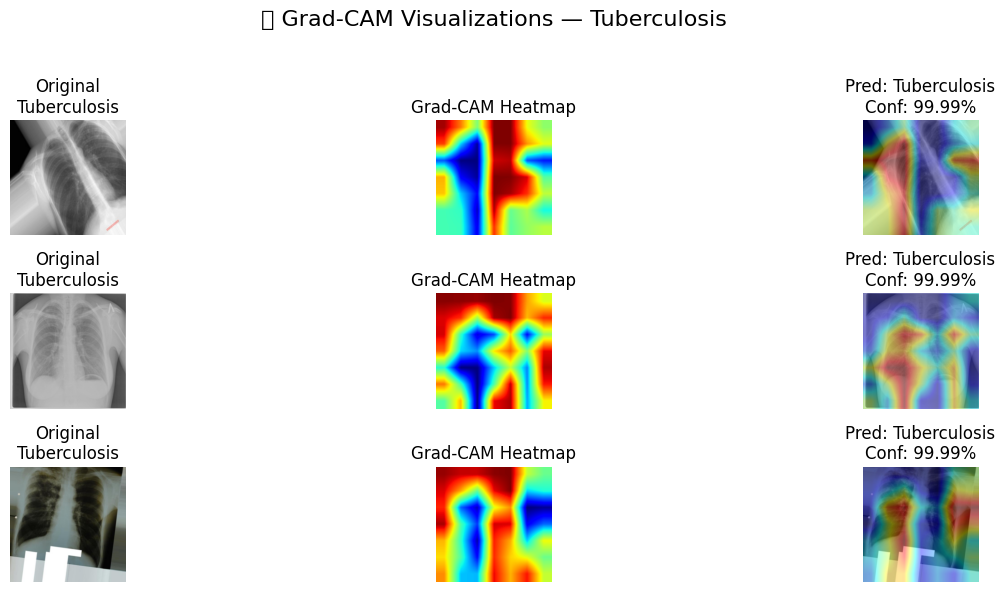

✅ Saved Grad-CAM visualizations for Tuberculosis in /content/drive/MyDrive/Lung_Disease_Results/GradCAM_Visualizations


✅ All Grad-CAM visualizations saved in: /content/drive/MyDrive/Lung_Disease_Results/GradCAM_Visualizations


In [ ]:
# =====================================================
# ✅ IMPORTS
# =====================================================
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from PIL import Image

# =====================================================
# ✅ PATHS
# =====================================================
weights_path = "/content/drive/MyDrive/Lung_Disease_Model_Best.keras"  # or .h5
test_dir = "/content/drive/MyDrive/Lung_Disease_Dataset_Balanced/test"
save_dir = "/content/drive/MyDrive/Lung_Disease_Results/GradCAM_Visualizations"
os.makedirs(save_dir, exist_ok=True)
print(f"📁 Grad-CAM outputs will be saved to:\n{save_dir}\n")

# =====================================================
# ✅ FIXED ATTENTION MODEL REBUILD (with Lambda shapes)
# =====================================================
def attention_block(x):
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(x.shape[-1] // 8, activation='relu')(gap)
    dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
    channel_att = layers.Multiply()([x, layers.Reshape((1, 1, x.shape[-1]))(dense2)])

    avg_pool = layers.Lambda(
        lambda z: tf.reduce_mean(z, axis=-1, keepdims=True),
        output_shape=lambda s: (s[0], s[1], s[2], 1)
    )(channel_att)
    max_pool = layers.Lambda(
        lambda z: tf.reduce_max(z, axis=-1, keepdims=True),
        output_shape=lambda s: (s[0], s[1], s[2], 1)
    )(channel_att)

    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_att = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([channel_att, spatial_att])

# Build model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = attention_block(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.load_weights(weights_path)
print("✅ Model weights loaded successfully!\n")

# =====================================================
# ✅ GRAD-CAM GENERATION FUNCTION
# =====================================================
def generate_gradcam(model, img_array, layer_name=None):
    """Generate Grad-CAM heatmap."""
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    grad_model = Model([model.input],
                       [model.get_layer(layer_name).output, model.output])

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return heatmap, int(pred_index), float(predictions[0][pred_index])

# =====================================================
# ✅ MULTI-IMAGE DISPLAY FUNCTION (3 per class)
# =====================================================
def gradcam_grid_for_class(class_name, class_labels):
    cls_path = os.path.join(test_dir, class_name)
    img_files = random.sample(os.listdir(cls_path), 3)

    plt.figure(figsize=(15, 6))
    for idx, img_file in enumerate(img_files):
        img_path = os.path.join(cls_path, img_file)
        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        heatmap, pred_idx, conf = generate_gradcam(model, img_array)
        pred_label = class_labels[pred_idx]

        # Overlay heatmap
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(np.uint8(np.array(img)), 0.6, heatmap_colored, 0.4, 0)

        # Original
        plt.subplot(3, 3, idx * 3 + 1)
        plt.imshow(img)
        plt.title(f"Original\n{class_name}")
        plt.axis('off')

        # Heatmap
        plt.subplot(3, 3, idx * 3 + 2)
        plt.imshow(heatmap_resized, cmap='jet')
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')

        # Overlay
        plt.subplot(3, 3, idx * 3 + 3)
        plt.imshow(overlay)
        plt.title(f"Pred: {pred_label}\nConf: {conf*100:.2f}%")
        plt.axis('off')

        save_path = os.path.join(save_dir, f"{class_name}_{pred_label}_sample{idx+1}_GradCAM.png")
        cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    plt.suptitle(f"🩻 Grad-CAM Visualizations — {class_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    print(f"✅ Saved Grad-CAM visualizations for {class_name} in {save_dir}\n")

# =====================================================
# ✅ RUN FOR ALL CLASSES
# =====================================================
class_labels = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
print(f"🩻 Classes Detected: {class_labels}\n")

for cls in class_labels:
    gradcam_grid_for_class(cls, class_labels)

print(f"\n✅ All Grad-CAM visualizations saved in: {save_dir}")
